In [ ]:
# !pip uninstall scispacy 

In [2]:
import scispacy
import spacy
import pandas as pd
import sys
from datetime import datetime 

In [3]:
nlp = spacy.load("en_core_sci_scibert")

In [ ]:
# notes = pd.read_csv("/users/k1810895/data/KER/data/mimic_notes.csv")

In [ ]:
# text = '''This is a 55 y/o M, with H/O Hep C ( presumed from blood transfusions
#    s/p 3 rd degree burns in an industrial accident in [**2111**]), with known
#    h/o varices who presented on [**3-26**]^th [**2144**] , with abdominal
#    distension,jaundice & found to have spontaneous bacterial peritonitis,
#    was admitted to [**Hospital Ward Name 383**] 10.
#    Change in mentation noted throughout the day, missed his lactulose dose
#    [**12-21**] to altered mental status unable to drink safely with risk of
#    aspiration, creatinine found to be 8.0 ( Baseline 0.8), BUN in 100
#    HD catheter with VIPort inserted & transferred to MICU 6 for further
#    management.
#    Events :
#    Patient dialyzed from [**2165**] hrs to 2230 hrs with only 500 mls fluid
#    removal [**12-21**] to Low BP during dialysis.
#    IV Albumin 100 grams given as per orders.
#    NGT inserted , had minimal bleeding during insertion. (INR 3.7 in am
#    lab- had received 4 units of FFP from [**Wardname **]). Had coffee ground NG
#    aspirate , connected to low intermittent suction until cleared. Due
#    dose of Lactulose given.
#    Hepatorenal syndrome
#    Assessment:
#    Patient is Anuric since am of [**2145-4-1**] as per report received from [**Hospital Ward Name 383**]
#    10. Labs drawb prior to Hemodialysis, Please see metavision for lab
#    values.
#    Action:
#    Patient had Hemodialysis done for 2 hours with 500 mls fluid removal
#    for the first time.
#    Response:
#    Renal function continues to be deranged in am labs, continues to be
#    anuric.
#    Plan:
#    Continue monitoring labs, To follow up on next HD
#    Electrolyte & fluid disorder, other
#    Assessment:
#    Action:
#    Response:
#    Plan:
#    Altered mental status (not Delirium)
#    Assessment:
#    Action:
#    Response:
#    Plan:
#    Hematemesis (upper GI bleed, UGIB)
#    Assessment:
#    Action:
#    Response:
#    Plan:
#    Bradycardia
#    Assessment:
#    Action:
#    Response:
#    Plan:
#    Hypotension (not Shock)
#    Assessment:
#    Action:
#    Response:
#    Plan:
# '''
# tokens = nlp(text)

# for sent in tokens.sents:
#     print(sent.text, sent.start_char, sent.end_char, sent.start, sent.end)

#### The formatt {"text": "Directed by Andrei Zagdansky Not rated ; 72 minutes In the documentary '' Orange Winter '' orange blooms throughout Kiev , Ukraine , the epicenter of dissent over that country 's stolen 2004 presidential elections .", "relation": "/location/country/capital", "h": {"id": "m.07t21", "name": "Ukraine", "pos": [123, 130]}, "t": {"id": "m.02sn34", "name": "Kiev", "pos": [116, 120]}}

## Identify concepts from sentences

All text are annoated with UMLS CUIs. Go through each sentence and find CUIs in each sentence. If a pair of CUIs have a relation defined in UMLS, label it as a positive sample.

Cannot go through local json outputs, since json files with the same ids may not contain the same set of documents. Need to load all the data to search, which is too big. 

Medcat does not provide sentence split cutoff in the results. So cannot get sentence infor in annotations. Scispacy provides such information. 

So:
1. Use sentence_seg.sh split documents into sentences. 
2. All annotations have been ingested to ES, which allows query, on openstack. 
3. Go through each sentences resulted from sentence_seg.sh and collect all annotations in the same sentence. 
4. Obtain positive and negative samples from openstack instead of hpc. 


The above process is too complicated. So using NLTK to split sentences and input the annotator to get annotations. 
using *_sentences.sh job scripts. 

Using NLTK is very slow and the outputs from NLTK sentence splitters are different from those from spacy. Finally, rewrite the parser for Medcat output and use the "sentence" object in the scispacy output to produce sentence-level annotations. 


## Enumerate all combinations of entity pairs in sentences

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import json
from itertools import combinations
from scipy import stats
from collections import Counter

In [2]:
rels = json.load(open('data/rel_map.json', 'r'))

In [3]:
list(rels.items())[:3]

[('C0000039-C0043950', {'rela': 'mapped_to', 'dir': 'N', 'rui': 'R148171650'}),
 ('C0000039-C0381030', {'rela': 'mapped_to', 'dir': 'N', 'rui': 'R148166148'}),
 ('C0000039-C0615231', {'rela': 'mapped_to', 'dir': 'N', 'rui': 'R148263106'})]

In [7]:
# notes.head()

In [4]:
stypes = pd.read_csv('data/types_list.csv')

In [5]:
stypes.head()

,TUI,Name,Relevant,Chapter,Example Concepts
0,T001,Organism,0,A1.1,"['Microorganism &#x7C; XXX', 'XXX microorganis..."
1,T002,Plant,0,A1.1.3.3,"['Grain &#x7C; bld-ser-plas', 'Chick pea (cice..."
2,T004,Fungus,1,A1.1.3.2,"['Yeast &#x7C; cervix', 'Yeast &#124; stool', ..."
3,T005,Virus,1,A1.1.4,"['Cytomegalovirus &#x7C; bld-ser-plas', 'Infec..."
4,T007,Bacterium,1,A1.1.2,"['Bacteria &#124; peritoneal fluid', 'Helicoba..."


In [6]:
type2chapter = pd.Series(stypes.Chapter.values,index=stypes.TUI).to_dict()

### Some documents are full of metrics and not provide useful language. So focus on discharge summary

In [13]:
# notes = pd.read_csv('/users/k1810895/data/KER/data/mimic_notes.csv')

In [14]:
# discharg_dids = set(notes[notes['category']=='Discharge summary']['row_id'].tolist())

In [16]:
# del notes

In [10]:
len(discharg_dids)

59652

In [11]:
discharg_dids = pd.read_csv('data/mimic_discharge_note_ids.csv')

In [17]:
discharg_dids = set(discharg_dids['row_id'].tolist())

In [18]:
len(discharg_dids)

59652

### Compare Medcat and Scispacy annotation granularity 

In [19]:
import pickle

In [20]:
apath = '/users/k1810895/data/KER/data/scispacy_sentences/'
bpath = '/users/k1810895/data/KER/data/medcat_sentence/'

In [21]:
def sentence_annots(path):
    annot_counts = []
    annot_types = []
    annot_chapters = []
    for index in range(1000):
        file_name = 'batch' + str(index) + '.json'

        docs = json.load(open(path+file_name, 'r'))

        for did in docs.keys():
            if int(did) in discharg_dids:
                sents = docs[did]
                for sid in sents.keys():
                    sent = sents[sid]
                    text = sent['sent_text']
                    annots = sent['sent_annots']
                    annot_counts.append(len(annots))
                    for annot in annots:
#                       Choose the first semantic type if multiple types are available
                        type_str = annot['types'].split(',')[0]
#                         annot_types.append(type_str)
                        cha = len(type2chapter[type_str].split('.'))
                        annot_chapters.append(cha)
    return annot_counts, annot_chapters

In [22]:
def sentence_annots_medcat(path):
    annot_counts = []
    annot_types = []
    annot_chapters = []
    for index in range(1000):
        file_name = 'batch' + str(index) + '.json'

        docs = json.load(open(path+file_name, 'r'))

        for did in docs.keys():
            if int(did) in discharg_dids:
                sents = docs[did]
                for sid in sents.keys():
                    sent = sents[sid]
                    text = sent['sent_text']
                    annots = sent['sent_annots']
                    annot_counts.append(len(annots))
                    for annot in annots:
#                       Choose the first semantic type if multiple types are available
                        type_str = annot['tui'].split(',')[0]
                        cha = len(type2chapter[type_str].split('.'))
                        annot_chapters.append(cha)
    return annot_counts, annot_chapters

In [16]:
a_counts, a_chapters = sentence_annots(apath)

In [18]:
b_counts, b_chapters = sentence_annots_medcat(bpath)

In [27]:
pickle.dump((a_counts, a_chapters), open('data/scispacy_annots_stat.pick', 'wb'))

In [28]:
pickle.dump((b_counts, b_chapters), open('data/medcat_annots_stat.pick', 'wb'))

#### Distribution of annotations' chapters

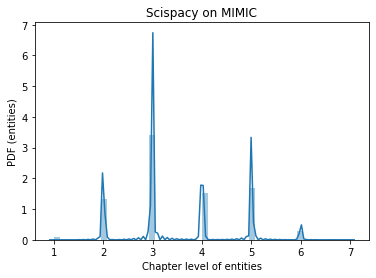

In [57]:
sns.distplot(a_chapters)
plt.xlabel("Chapter level of entities")
plt.ylabel("PDF (entities)")
plt.title("Scispacy on MIMIC")
plt.show()

In [50]:
c = Counter(a_chapters)
for i in range(1, 8):
    print(i, c[i], c[i]/len(a_chapters))

1 272052 0.01225898574119883
2 3501830 0.15779661255238814
3 9058066 0.4081671957450705
4 4090146 0.18430682918494048
5 4481730 0.20195206859682352
6 784014 0.03532860058702108
7 4210 0.00018970759255747824


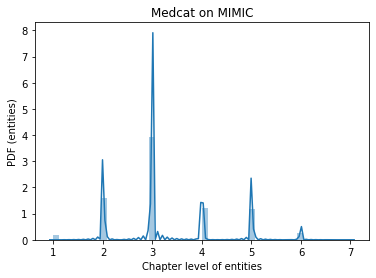

In [58]:
sns.distplot(b_chapters)
plt.xlabel("Chapter level of entities")
plt.ylabel("PDF (entities)")
plt.title("Medcat on MIMIC")
plt.show()

In [51]:
c = Counter(b_chapters)
for i in range(1, 8):
    print(i, c[i], c[i]/len(b_chapters))

1 662919 0.021306254178609107
2 5986285 0.1923995387001957
3 14643883 0.47065522840620483
4 4469441 0.1436480866927888
5 4362863 0.14022266374089304
6 988393 0.03176700695915789
7 38 1.2213221506506015e-06


#### Scispacy produces more fine grained concepts than Medcat

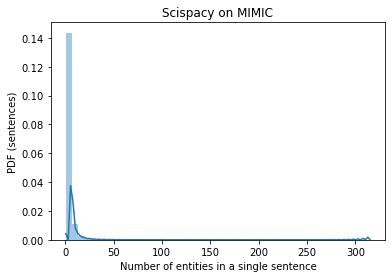

In [55]:
sns.distplot(a_counts)
plt.xlabel("Number of entities in a single sentence")
plt.ylabel("PDF (sentences)")
plt.title("Scispacy on MIMIC")
plt.show()

In [33]:
stats.describe(a_counts)

DescribeResult(nobs=5322252, minmax=(1, 315), mean=4.169672537113988, variance=23.177535766743144, skewness=7.137712520076788, kurtosis=101.30446871524101)

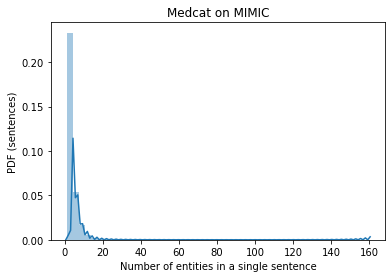

In [56]:
sns.distplot(b_counts)
plt.xlabel("Number of entities in a single sentence")
plt.ylabel("PDF (sentences)")
plt.title("Medcat on MIMIC")
plt.show()

In [35]:
stats.describe(b_counts)

DescribeResult(nobs=8754186, minmax=(1, 160), mean=3.5541650588644105, variance=11.60929167019811, skewness=4.334075299061011, kurtosis=44.70064103162898)

#### Scispacy produces a larger number of annotations than Medcat. A possible reason is that Medcat use the longest string match in choosing concept candidates

### Some sentences contain too many concepts. Following Mintz's paper, only focus on setences contaning two entities in training data but consider all pairs of entities in test data. The training data will tend to be short sentences. 

### Scispacy does not allow to choose a subset of voc. 

In [46]:
def screen_sentences(path, output_file):
    with open(output_file, 'w') as fw:
        for index in range(1000):
            file_name = 'batch' + str(index) + '.json'

            docs = json.load(open(path+file_name, 'r'))

            for did in docs.keys():
                if int(did) in discharg_dids:
#                 if True:
                    sents = docs[did]
                    for sid in sents.keys():
                        sent = sents[sid]
                        text = sent['sent_text']
                        annots = sent['sent_annots']
                        # If include all sentence with any number of annotations. it ends with a super large file
                        # Select centain types of annotations to focus.  
                        if len(annots) == 2:
                            for ai, aj in combinations(annots, 2):
                                ai_cui, aj_cui = ai['cui'], aj['cui']
                                es = {}
                                ei = {"id": ai_cui, "name": ai['text'], "pos": [ai['start_char'], ai['end_char']]}
                                ej = {"id": aj_cui, "name": aj['text'], "pos": [aj['start_char'], aj['end_char']]}

                                min_cui, max_cui = ai_cui, aj_cui
                                es[min_cui] = ei
                                es[max_cui] = ej
                                if ai_cui > aj_cui:
                                    min_cui, max_cui = aj_cui, ai_cui
                                    es[min_cui] = ej
                                    es[max_cui] = ei

                                cui_key = min_cui + '-' + max_cui
        #                                 rel = 'NA'
        #                                 dire = 'Y'
        #                             Too many combination of entity pairs in a sentence. So two many NA negative samples 
        # Also, a sentence can have multiple instances, which 
                                if cui_key in rels:
                                    rel = rels[cui_key]['rela']
                                    dire = rels[cui_key]['dir']
                                    if dire == 'Y':
                                        head, tail = es[min_cui], es[max_cui]
                                    else:
                                        tail, head = es[min_cui], es[max_cui]
                                    fw.write(str({'text': text, 'relation': rel, 'h': head, 't': tail}) + '\n')


In [48]:
screen_sentences(apath, '/users/k1810895/data/KER/data/scispacy_sentences.txt')

In [49]:
screen_sentences(bpath, '/users/k1810895/data/KER/data/medcat_sentences.txt')

#### There are 59345 relevant positive sentences from scispacy annotations. and 129748 relevant positive sentences from medcat annotations. 

The formatt {"text": "Directed by Andrei Zagdansky Not rated ; 72 minutes In the documentary '' Orange Winter '' orange blooms throughout Kiev , Ukraine , the epicenter of dissent over that country 's stolen 2004 presidential elections .", "relation": "/location/country/capital", "h": {"id": "m.07t21", "name": "Ukraine", "pos": [123, 130]}, "t": {"id": "m.02sn34", "name": "Kiev", "pos": [116, 120]}}

## Negation relations

Rule-based method: https://github.com/lhncbc/SemRep 
